### Cleaning Macroecon Data
This notebook imputes missing macroeconomics data and converts messy string data into a standardized numeric form. 

#### Load Libraries

In [43]:
# Wrangling libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#### Importing Data

In [2]:
# Load data
data = pd.read_csv("../04data/raw/econdata.csv")

# Check current column data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 22 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   Date                                                                           406 non-null    object 
 1   Quarter                                                                        406 non-null    object 
 2   Year                                                                           406 non-null    int64  
 3   5 year bond yields                                                             406 non-null    float64
 4   GDPm (Current Prices)                                                          405 non-null    object 
 5   GDP per capita                                                                 396 non-null    object 
 6   GNI per capita            

From the table above, we can see the numbers that need to be changed are (a) date, (b) GDPm (Current Prices), (c) GDP per capita, (d) GNI per capita, (e) Personal Income, (f) Median Household Inc

#### Convert numerical forms

In [3]:
data.head()


,Date,Quarter,Year,5 year bond yields,GDPm (Current Prices),GDP per capita,GNI per capita,Personal Income m,Unemployment Rate,Core inflation,...,1-Room Residential Properties,2-Room Residential Properties,3-Room Residential Properties,4-Room Residential Properties,5-Room Residential Properties,Executive Properties,"Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials",Clay Construction Materials & Refractory Construction Materials,Stamp Duty,LTV Value
0,Jan-90,1990 1Q,1990,5.22,"16,669.50","22,901.00","23,134.00","9,046.80",NaN,61.59,...,28697.0,42206.0,252044.0,202046.0,71754.0,21602.0,99.488,81.242,0.03,0.9
1,Feb-90,1990 1Q,1990,5.16,"16,669.50","22,901.00","23,134.00","9,046.80",NaN,61.70,...,28697.0,42206.0,252044.0,202046.0,71754.0,21602.0,98.948,81.167,0.03,0.9
2,Mar-90,1990 1Q,1990,5.22,"16,669.50","22,901.00","23,134.00","9,046.80",NaN,61.48,...,28697.0,42206.0,252044.0,202046.0,71754.0,21602.0,101.752,80.572,0.03,0.9
3,Apr-90,1990 2Q,1990,5.34,"17,087.70","22,901.00","23,134.00","9,460.30",NaN,61.86,...,28697.0,42206.0,252044.0,202046.0,71754.0,21602.0,102.506,80.647,0.03,0.9
4,May-90,1990 2Q,1990,5.25,"17,087.70","22,901.00","23,134.00","9,460.30",NaN,61.99,...,28697.0,42206.0,252044.0,202046.0,71754.0,21602.0,103.799,80.200,0.03,0.9


From the output above, we can see that:
- (a) date is in the format: MMM-YY, Jan-90
  - This can be fixed with the pandas date time function by specifying the format.
- (b) GDPm (Current Prices), (c) GDP per capita, (d) GNI per capita, (e) Personal Income, (f) Median Household Inc have the same issue: 
  - Their numbers have commas and periods.
  - These can easily be removed with a string replace method. 

In [4]:
# Convert Date column to date-time
data['Date'] = pd.to_datetime(data['Date'], format='%b-%y')

# Convert necessary columns to numeric
data['GDPm (Current Prices)'] = data['GDPm (Current Prices)'].str.replace(',', '')
data['GDPm (Current Prices)'] = pd.to_numeric(data['GDPm (Current Prices)'])

data['GDP per capita'] = data['GDP per capita'].str.replace(',', '')
data['GDP per capita'] = pd.to_numeric(data['GDP per capita'])

data['GNI per capita'] = data['GNI per capita'].str.replace(',', '')
data['GNI per capita'] = pd.to_numeric(data['GNI per capita'])

data['Personal Income m'] = data['Personal Income m'].str.replace(',', '')
data['Personal Income m'] = pd.to_numeric(data['Personal Income m'])

data['Median Household Inc'] = data['Median Household Inc'].str.replace(',', '')
data['Median Household Inc'] = pd.to_numeric(data['Median Household Inc'])


#### Dealing with Missing Data
Understanding number of nulls in order to understand what needs to be inputed


In [5]:
# Count number of nulls per row
data.isnull().sum()


Date                                                                              0
Quarter                                                                           0
Year                                                                              0
5 year bond yields                                                                0
GDPm (Current Prices)                                                             1
GDP per capita                                                                   10
GNI per capita                                                                   10
Personal Income m                                                                 1
Unemployment Rate                                                                24
Core inflation                                                                    0
Median Household Inc                                                              0
Total Residential Properties                                                

##### Imputing Null Data
From null count above, we can see that the columns that need to be imputed are:
- (a) GDPm (Current Prices) - 1 month missing
- (b) GDP per capita - 2023 ytd missing
- (c) GNI per capita - 2023 ytd missing
- (d) Personal Income m - 1 month missing
- (e) Unemployment Rate - 2 years missing
- (f) Total Residential Properties and subset - 2023 ytd missing
- (g) Lime, Cement & Fabricated Construction Materials Excl Glass & Clay Materials - 1 month missing
- (h) Clay Construction Materials & Refractory Construction Materials - 1 month missing


##### (a) Imputing GDPm (Current Prices)

In [8]:
# 1. Create dataframe with GDPm
GDPm = data[['Date', 'GDPm (Current Prices)']].dropna()

# 2. Calculate the percentage change
GDPm['pct_change'] = GDPm['GDPm (Current Prices)'].pct_change()

# 3. Check data
GDPm.tail()


,Date,GDPm (Current Prices),pct_change
400,2023-05-01,163156.5,0.000000
401,2023-06-01,163156.5,0.000000
402,2023-07-01,164868.1,0.010491
403,2023-08-01,164868.1,0.000000
404,2023-09-01,164868.1,0.000000


In [9]:
## GDP imputation rule: calculate Oct 2023 GDP by multiplying Sep 2023 GDP by Q3 GDP percentage change

# 4. Save percentage change variable:
Q3_pct_change = GDPm.loc[GDPm['Date']=='2023-07-01']['pct_change'].iloc[0]

# 5. Save Sep 2023 variable:
sep_2023_value = GDPm.loc[GDPm['Date'] == '2023-09-01	']['GDPm (Current Prices)'].iloc[0]

# 6. Calculate Oct 2023 variable:
oct_2023_value = sep_2023_value * (1+Q3_pct_change)

# 7. Assign Oct 2023 variable:
data.at[data.index[-1], 'GDPm (Current Prices)'] = oct_2023_value

# 8. Check data
data.at[data.index[-1], 'GDPm (Current Prices)']


166597.65561047217

##### (b) Imputing GDP per capita


In [10]:
# 1. Create separate dataframe to calculate percentage change
GDP_per_capita = data[['Year', 'GDP per capita']]

# 2. Find yearly GDP value (data provided on an annual basis)
GDP_per_capita = GDP_per_capita.groupby('Year').mean()

# 3. Calculate percentage change, reset index
GDP_per_capita['pct_change'] = GDP_per_capita['GDP per capita'].pct_change()
GDP_per_capita = GDP_per_capita.reset_index()


/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/4101207776.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  GDP_per_capita['pct_change'] = GDP_per_capita['GDP per capita'].pct_change()


In [11]:
## GDP imputation rule: calculate 2023 GDP by multiplying 2022 GDP per capita by 2022 percentage change

# 4 Save percentage change variable:
prev_year_GDP_pct_change = GDP_per_capita.loc[GDP_per_capita['Year']==2022]['pct_change'].iloc[0]

# 5 Save Sep 2023 variable:
gdp_per_cap_2022 = GDP_per_capita.loc[GDP_per_capita['Year'] == 2022]['GDP per capita'].iloc[0]

# 6 Calculate Oct 2023 variable:
gdp_per_cap_2023 = gdp_per_cap_2022 * (1+prev_year_GDP_pct_change)

# 7 Assign Oct 2023 variable:
data.iloc[-10:, data.columns.get_loc('GDP per capita')] = gdp_per_cap_2023


##### (c) Imputing GNI per capita


In [12]:
# 1. Create separate dataframe to calculate percentage change
GNI_per_capita = data[['Year', 'GNI per capita']]

# 2. Find yearly GDP value (data provided on an annual basis)
GNI_per_capita = GNI_per_capita.groupby('Year').mean()

# 3. Calculate percentage change, reset index
GNI_per_capita['pct_change'] = GNI_per_capita['GNI per capita'].pct_change()
GNI_per_capita = GNI_per_capita.reset_index()


/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/632933991.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  GNI_per_capita['pct_change'] = GNI_per_capita['GNI per capita'].pct_change()


In [13]:
## GNI imputation rule: calculate 2023 GNI by multiplying 2022 GNI per capita by 2022 percentage change

# 4. Save percentage change variable:
prev_year_GNI_pct_change = GNI_per_capita.loc[GNI_per_capita['Year']==2022]['pct_change'].iloc[0]

# 5. Save Sep 2023 variable:
GNI_per_cap_2022 = GNI_per_capita.loc[GNI_per_capita['Year'] == 2022]['GNI per capita'].iloc[0]

# 6. Calculate Oct 2023 variable:
GNI_per_cap_2023 = GNI_per_cap_2022 * (1+prev_year_GNI_pct_change)

# 7. Assign Oct 2023 variable:
data.iloc[-10:, data.columns.get_loc('GNI per capita')] = GNI_per_cap_2023


##### (d) Personal Income


In [14]:
# 1. Create personal income dataframe
personalinc = data[['Date', 'Personal Income m']]

# 2. Calculate percentage change
personalinc['pct_change'] = personalinc['Personal Income m'].pct_change()


/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/869604857.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  personalinc['pct_change'] = personalinc['Personal Income m'].pct_change()
/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/869604857.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalinc['pct_change'] = personalinc['Personal Income m'].pct_change()


In [15]:
## Personal income imputation rule: calculate Oct 2023 personal inc by multiplying Sep 2023 personal inc by Q3 personal inc percentage change

# 4. Save percentage change variable:
personalinc_Q3_pct_change = personalinc.loc[personalinc['Date']=='2023-07-01']['pct_change'].iloc[0]

# 5. Save Sep 2023 variable:
personalinc_sep_2023 = personalinc.loc[personalinc['Date'] == '2023-09-01']['Personal Income m'].iloc[0]

# 6. Calculate Oct 2023 variable:
personalinc_oct_2023 = personalinc_sep_2023 * (1+personalinc_Q3_pct_change)

# 7. Assign Oct 2023 variable:
data.at[data.index[-1], 'Personal Income m'] = personalinc_oct_2023


##### (e) Unemployment Rate


In [16]:
## Imputation rule: assume that the unemployment rate in 1990 and 1991 was the same as 1992:

# 1. Obtain earliest availble value from Jan 1992
ue_earliest_value = data[data['Date']=='1992-01-01']['Unemployment Rate'].iloc[0]

# 2. Fill first two years of data with the earliest value
data.iloc[0:24, data.columns.get_loc('Unemployment Rate')] = ue_earliest_value


##### (f) Total Residental Properties and Subset

In [17]:
# 1. Create separate dataframe to calculate percentage change
total_residence = data[['Year', 'Total Residential Properties']]

# 2. Find yearly value (data provided on an annual basis)
total_residence = total_residence.groupby('Year').mean()

# 3. Calculate percentage change, reset index
total_residence['pct_change'] = total_residence['Total Residential Properties'].pct_change()
total_residence = total_residence.reset_index()


/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/3295129414.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  total_residence['pct_change'] = total_residence['Total Residential Properties'].pct_change()


In [18]:
## Total residential units imputation rule: calculate 2023 value by multiplying 2022 value by 2022 percentage change

# 4. Save percentage change variable:
prev_year_totalres_pct_change = total_residence.loc[total_residence['Year']==2022]['pct_change'].iloc[0]

# 5. Save Sep 2023 variable:
totalres_2022 = total_residence.loc[total_residence['Year'] == 2022]['Total Residential Properties'].iloc[0]

# 6. Calculate Oct 2023 variable:
totalres_2023 = totalres_2022 * (1+prev_year_totalres_pct_change)

# 7. Assign Oct 2023 variable:
data.iloc[-10:, data.columns.get_loc('Total Residential Properties')] = totalres_2023


##### 1 Room Residences

In [19]:
# 1. Create separate dataframe to calculate percentage change
room1_residence = data[['Year', '  1-Room Residential Properties']]

# 2. Find yearly value (data provided on an annual basis)
room1_residence = room1_residence.groupby('Year').mean()

# 3. Calculate percentage change, reset index
room1_residence['pct_change'] = room1_residence['  1-Room Residential Properties'].pct_change()
room1_residence = room1_residence.reset_index()


/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/3128219208.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  room1_residence['pct_change'] = room1_residence['  1-Room Residential Properties'].pct_change()


In [20]:
## 1-room residential units imputation rule: calculate 2023 value by multiplying 2022 value by 2022 percentage change

# 4. Save percentage change variable:
prev_year_room1_pct_change = room1_residence.loc[room1_residence['Year']==2022]['pct_change'].iloc[0]

# 5. Save Sep 2023 variable:
room1_2022 = room1_residence.loc[room1_residence['Year'] == 2022]['  1-Room Residential Properties'].iloc[0]

# 6. Calculate Oct 2023 variable:
room1_2023 = room1_2022 * (1+prev_year_room1_pct_change)

# 7. Assign Oct 2023 variable:
data.iloc[-10:, data.columns.get_loc('  1-Room Residential Properties')] = room1_2023


#### 2 Room Residences

In [21]:
# 1. Create separate dataframe to calculate percentage change
room2_residence = data[['Year', '  2-Room Residential Properties']]

# 2. Find yearly value (data provided on an annual basis)
room2_residence = room2_residence.groupby('Year').mean()

# 3. Calculate percentage change, reset index
room2_residence['pct_change'] = room2_residence['  2-Room Residential Properties'].pct_change()
room2_residence = room2_residence.reset_index()


/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/2453691041.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  room2_residence['pct_change'] = room2_residence['  2-Room Residential Properties'].pct_change()


In [22]:
## 2-room residential units imputation rule: calculate 2023 value by multiplying 2022 value by 2022 percentage change

# 4. Save percentage change variable:
prev_year_room2_pct_change = room2_residence.loc[room2_residence['Year']==2022]['pct_change'].iloc[0]

# 5. Save Sep 2023 variable:
room2_2022 = room2_residence.loc[room2_residence['Year'] == 2022]['  2-Room Residential Properties'].iloc[0]

# 6. Calculate Oct 2023 variable:
room2_2023 = room2_2022 * (1+prev_year_room2_pct_change)

# 7. Assign Oct 2023 variable:
data.iloc[-10:, data.columns.get_loc('  2-Room Residential Properties')] = room2_2023


#### 3 Room Residences

In [23]:
# 1. Create separate dataframe to calculate percentage change
room3_residence = data[['Year', '  3-Room Residential Properties']]

# 2. Find yearly value (data provided on an annual basis)
room3_residence = room3_residence.groupby('Year').mean()

# 3. Calculate percentage change, reset index
room3_residence['pct_change'] = room3_residence['  3-Room Residential Properties'].pct_change()
room3_residence = room3_residence.reset_index()


/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/2728727190.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  room3_residence['pct_change'] = room3_residence['  3-Room Residential Properties'].pct_change()


In [24]:
## 3-room residential units imputation rule: calculate 2023 value by multiplying 2022 value by 2022 percentage change

# 4. Save percentage change variable:
prev_year_room3_pct_change = room3_residence.loc[room3_residence['Year']==2022]['pct_change'].iloc[0]

# 5. Save 2022 variable:
room3_2022 = room3_residence.loc[room3_residence['Year'] == 2022]['  3-Room Residential Properties'].iloc[0]

# 6. Calculate 2023 variable:
room3_2023 = room3_2022 * (1+prev_year_room3_pct_change)

# 7. Assign 2023 variable:
data.iloc[-10:, data.columns.get_loc('  3-Room Residential Properties')] = room3_2023


#### 4 Room Residences

In [25]:
# 1. Create separate dataframe to calculate percentage change
room4_residence = data[['Year', '  4-Room Residential Properties']]

# 2. Find yearly value (data provided on an annual basis)
room4_residence = room4_residence.groupby('Year').mean()

# 3. Calculate percentage change, reset index
room4_residence['pct_change'] = room4_residence['  4-Room Residential Properties'].pct_change()
room4_residence = room4_residence.reset_index()


/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/3588138699.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  room4_residence['pct_change'] = room4_residence['  4-Room Residential Properties'].pct_change()


In [26]:
## 4-room residential units imputation rule: calculate 2023 value by multiplying 2022 value by 2022 percentage change

# 4 Save percentage change variable:
prev_year_room4_pct_change = room4_residence.loc[room4_residence['Year']==2022]['pct_change'].iloc[0]

# 5 Save 2023 variable:
room4_2022 = room4_residence.loc[room4_residence['Year'] == 2022]['  4-Room Residential Properties'].iloc[0]

# 6 Calculate 2023 variable:
room4_2023 = room4_2022 * (1+prev_year_room4_pct_change)

# 7 Assign 2023 variable:
data.iloc[-10:, data.columns.get_loc('  4-Room Residential Properties')] = room4_2023


#### 5 Room Residences

In [27]:
# 1. Create separate dataframe to calculate percentage change
room5_residence = data[['Year', '  5-Room Residential Properties']]

# 2. Find yearly value (data provided on an annual basis)
room5_residence = room5_residence.groupby('Year').mean()

# 3. Calculate percentage change, reset index
room5_residence['pct_change'] = room5_residence['  5-Room Residential Properties'].pct_change()
room5_residence = room5_residence.reset_index()


/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/1386270977.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  room5_residence['pct_change'] = room5_residence['  5-Room Residential Properties'].pct_change()


In [28]:
## 5-room residential units imputation rule: calculate 2023 value by multiplying 2022 value by 2022 percentage change

# 4. Save percentage change variable:
prev_year_room5_pct_change = room5_residence.loc[room5_residence['Year']==2022]['pct_change'].iloc[0]

# 5. Save 2023 variable:
room5_2022 = room5_residence.loc[room5_residence['Year'] == 2022]['  5-Room Residential Properties'].iloc[0]

# 6. Calculate 2023 variable:
room5_2023 = room5_2022 * (1+prev_year_room5_pct_change)

# 7. Assign 2023 variable:
data.iloc[-10:, data.columns.get_loc('  5-Room Residential Properties')] = room5_2023


#### Executive Properties

In [29]:
# 1. Create separate dataframe to calculate percentage change
exec_residence = data[['Year', '  Executive Properties']]

# 2. Find yearly value (data provided on an annual basis)
exec_residence = exec_residence.groupby('Year').mean()

# 3. Calculate percentage change, reset index
exec_residence['pct_change'] = exec_residence['  Executive Properties'].pct_change()
exec_residence = exec_residence.reset_index()


/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/2611726422.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  exec_residence['pct_change'] = exec_residence['  Executive Properties'].pct_change()


In [30]:
## Exec residential units imputation rule: calculate 2023 value by multiplying 2022 value by 2022 percentage change

# 4. Save percentage change variable:
prev_year_exec_pct_change = exec_residence.loc[exec_residence['Year']==2022]['pct_change'].iloc[0]

# 5. Save Sep 2023 variable:
exec_2022 = exec_residence.loc[exec_residence['Year'] == 2022]['  Executive Properties'].iloc[0]

# 6. Calculate Oct 2023 variable:
exec_2023 = exec_2022 * (1+prev_year_exec_pct_change)

# 7. Assign Oct 2023 variable:
data.iloc[-10:, data.columns.get_loc('  Executive Properties')] = exec_2023


#### 1(g) Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials 

In [32]:
# 1. Create dataframe
cement = data[['Date', 'Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials']]

# 2. Calculate percentage change
cement['pct_change'] = cement['Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials'].pct_change()


/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/1586968800.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  cement['pct_change'] = cement['Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials'].pct_change()
/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/1586968800.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cement['pct_change'] = cement['Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials'].pct_change()


In [34]:
## Cement construction inflation imputation rule: calculate Oct 2023 value by multiplying Sep 2023 value by Q3 percentage change

# 4. Save percentage change variable:
cement_Q3_pct_change = cement.loc[cement['Date']=='2023-07-01']['pct_change'].iloc[0]

# 5. Save Sep 2023 variable:
cement_sep_2023 = cement.loc[cement['Date'] == '2023-09-01']['Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials'].iloc[0]

# 6. Calculate Oct 2023 variable:
cement_oct_2023 = cement_sep_2023 * (1+cement_Q3_pct_change)

# 7. Assign Oct 2023 variable:
data.at[data.index[-1], 'Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials'] = cement_oct_2023


#### 1(h) Clay Construction Materials & Refractory Construction Materials

In [35]:
# 1. Create dataframe
clay = data[['Date', 'Clay Construction Materials & Refractory Construction Materials']]

# 2. Calculate percentage change
clay['pct_change'] = clay['Clay Construction Materials & Refractory Construction Materials'].pct_change()


/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/1007408120.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  clay['pct_change'] = clay['Clay Construction Materials & Refractory Construction Materials'].pct_change()
/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/1007408120.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clay['pct_change'] = clay['Clay Construction Materials & Refractory Construction Materials'].pct_change()


In [36]:
## Clay construction inflation imputation rule: calculate Oct 2023 value by multiplying Sep 2023 value by Q3 percentage change

# 4. Save percentage change variable:
clay_Q3_pct_change = clay.loc[clay['Date']=='2023-07-01']['pct_change'].iloc[0]

# 5. Save Sep 2023 variable:
clay_sep_2023 = clay.loc[clay['Date'] == '2023-09-01']['Clay Construction Materials & Refractory Construction Materials'].iloc[0]

# 6. Calculate Oct 2023 variable:
clay_oct_2023 = clay_sep_2023 * (1+clay_Q3_pct_change)

# 7. Assign Oct 2023 variable:
data.at[data.index[-1], 'Clay Construction Materials & Refractory Construction Materials'] = clay_oct_2023


In [38]:
# check new dataframe (transposed for easier viewing)
data.head().T


,0,1,2,3,4
Date,1990-01-01 00:00:00,1990-02-01 00:00:00,1990-03-01 00:00:00,1990-04-01 00:00:00,1990-05-01 00:00:00
Quarter,1990 1Q,1990 1Q,1990 1Q,1990 2Q,1990 2Q
Year,1990,1990,1990,1990,1990
5 year bond yields,5.22,5.16,5.22,5.34,5.25
GDPm (Current Prices),16669.5,16669.5,16669.5,17087.7,17087.7
GDP per capita,22901.0,22901.0,22901.0,22901.0,22901.0
GNI per capita,23134.0,23134.0,23134.0,23134.0,23134.0
Personal Income m,9046.8,9046.8,9046.8,9460.3,9460.3
Unemployment Rate,1.8,1.8,1.8,1.8,1.8
Core inflation,61.59,61.7,61.48,61.86,61.99


#### Inflation Metrics

In [39]:
# Calculate a metric for monthly inflation
data['yearly core inflation'] = data['Core inflation'].pct_change()
data['yearly cement inflation'] = data['Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials'].pct_change()
data['yearly clay inflation'] = data['Clay Construction Materials & Refractory Construction Materials'].pct_change()

# Equate first month's inflation to earliest available value's inflation
coreinf_earliest_value = data[data['Date']=='1990-02-01']['yearly core inflation'].iloc[0]
data.iloc[0, data.columns.get_loc('yearly core inflation')] = coreinf_earliest_value

cementinf_earliest_value = data[data['Date']=='1990-02-01']['yearly cement inflation'].iloc[0]
data.iloc[0, data.columns.get_loc('yearly cement inflation')] = cementinf_earliest_value

clayinf_earliest_value = data[data['Date']=='1990-02-01']['yearly clay inflation'].iloc[0]
data.iloc[0, data.columns.get_loc('yearly clay inflation')] = clayinf_earliest_value


#### Check Processed Data, Save to CSV

In [40]:
# check new dataframe (transposed for easier viewing)
data.head().T

,0,1,2,3,4
Date,1990-01-01 00:00:00,1990-02-01 00:00:00,1990-03-01 00:00:00,1990-04-01 00:00:00,1990-05-01 00:00:00
Quarter,1990 1Q,1990 1Q,1990 1Q,1990 2Q,1990 2Q
Year,1990,1990,1990,1990,1990
5 year bond yields,5.22,5.16,5.22,5.34,5.25
GDPm (Current Prices),16669.5,16669.5,16669.5,17087.7,17087.7
GDP per capita,22901.0,22901.0,22901.0,22901.0,22901.0
GNI per capita,23134.0,23134.0,23134.0,23134.0,23134.0
Personal Income m,9046.8,9046.8,9046.8,9460.3,9460.3
Unemployment Rate,1.8,1.8,1.8,1.8,1.8
Core inflation,61.59,61.7,61.48,61.86,61.99


In [41]:
# check for null values (should be 0 at this stage)
data.isnull().sum()


Date                                                                             0
Quarter                                                                          0
Year                                                                             0
5 year bond yields                                                               0
GDPm (Current Prices)                                                            0
GDP per capita                                                                   0
GNI per capita                                                                   0
Personal Income m                                                                0
Unemployment Rate                                                                0
Core inflation                                                                   0
Median Household Inc                                                             0
Total Residential Properties                                                     0
  1-

In [46]:
# check for data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 25 columns):
 #   Column                                                                         Non-Null Count  Dtype         
---  ------                                                                         --------------  -----         
 0   Date                                                                           406 non-null    datetime64[ns]
 1   Quarter                                                                        406 non-null    object        
 2   Year                                                                           406 non-null    int64         
 3   5 year bond yields                                                             406 non-null    float64       
 4   GDPm (Current Prices)                                                          406 non-null    float64       
 5   GDP per capita                                                                 406 no

In [42]:
# save processed data to a *new* csv
#econdata_processed = data.to_csv('../data/processed/econdata_processed.csv', index=False)


#### Quick Visualisation of Data

,Year,5 year bond yields,GDPm (Current Prices),GDP per capita,GNI per capita,Personal Income m,Unemployment Rate,Core inflation,Median Household Inc,Total Residential Properties,...,4-Room Residential Properties,5-Room Residential Properties,Executive Properties,"Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials",Clay Construction Materials & Refractory Construction Materials,Stamp Duty,LTV Value,yearly core inflation,yearly cement inflation,yearly clay inflation
0,1990,5.22,16669.50000,22901.000000,23134.000000,9046.800000,1.8,61.59,2296.00,6.238210e+05,...,202046.000000,71754.000000,21602.000000,99.488000,81.242000,0.03,0.9,0.001786,-0.005428,-0.000923
1,1990,5.16,16669.50000,22901.000000,23134.000000,9046.800000,1.8,61.70,2296.00,6.238210e+05,...,202046.000000,71754.000000,21602.000000,98.948000,81.167000,0.03,0.9,0.001786,-0.005428,-0.000923
2,1990,5.22,16669.50000,22901.000000,23134.000000,9046.800000,1.8,61.48,2296.00,6.238210e+05,...,202046.000000,71754.000000,21602.000000,101.752000,80.572000,0.03,0.9,-0.003566,0.028338,-0.007331
3,1990,5.34,17087.70000,22901.000000,23134.000000,9460.300000,1.8,61.86,2296.00,6.238210e+05,...,202046.000000,71754.000000,21602.000000,102.506000,80.647000,0.03,0.9,0.006181,0.007410,0.000931
4,1990,5.25,17087.70000,22901.000000,23134.000000,9460.300000,1.8,61.99,2296.00,6.238210e+05,...,202046.000000,71754.000000,21602.000000,103.799000,80.200000,0.03,0.9,0.002102,0.012614,-0.005543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,2023,3.12,163156.50000,105089.446202,124840.972635,79248.600000,1.9,109.16,9028.98,1.127967e+06,...,447902.774905,253641.900983,65117.000015,129.174000,134.399000,0.06,0.8,0.001836,-0.011101,-0.001575
402,2023,2.98,164868.10000,105089.446202,124840.972635,80545.100000,1.9,109.38,9028.98,1.127967e+06,...,447902.774905,253641.900983,65117.000015,127.829000,134.211000,0.06,0.8,0.002015,-0.010412,-0.001399
403,2023,3.11,164868.10000,105089.446202,124840.972635,80545.100000,1.9,109.47,9028.98,1.127967e+06,...,447902.774905,253641.900983,65117.000015,129.357000,134.471000,0.06,0.8,0.000823,0.011953,0.001937
404,2023,3.34,164868.10000,105089.446202,124840.972635,80545.100000,1.9,109.60,9028.98,1.127967e+06,...,447902.774905,253641.900983,65117.000015,128.143000,134.687000,0.06,0.8,0.001188,-0.009385,0.001606


/var/folders/xl/pt0g2qn532q7v2xjqqjnf4d80000gn/T/ipykernel_54113/1127967710.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)


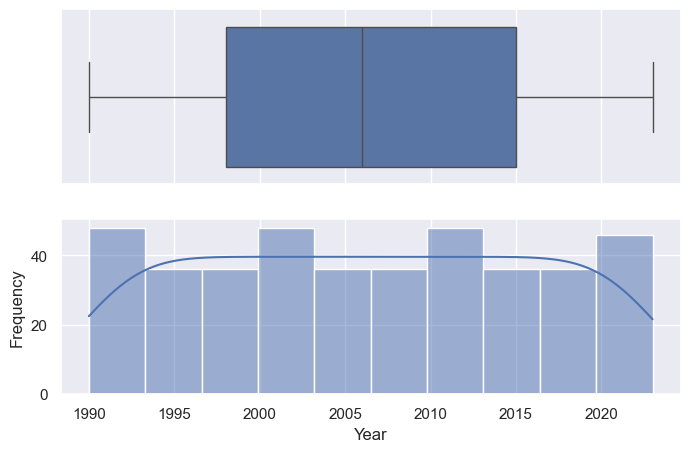

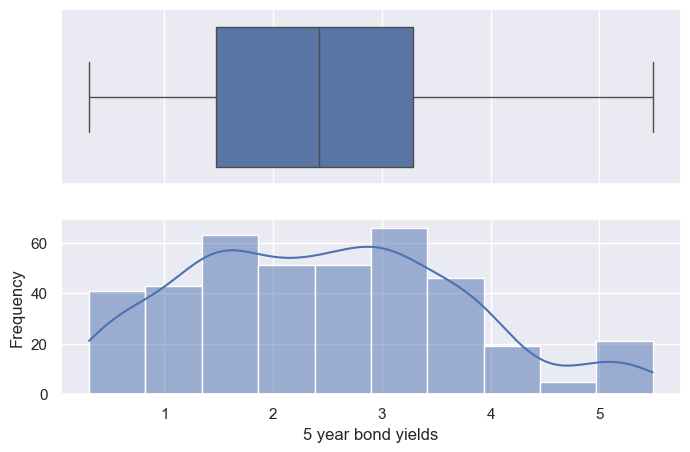

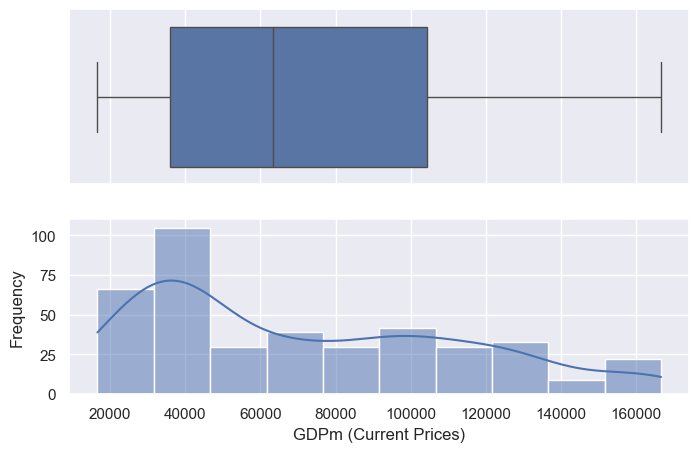

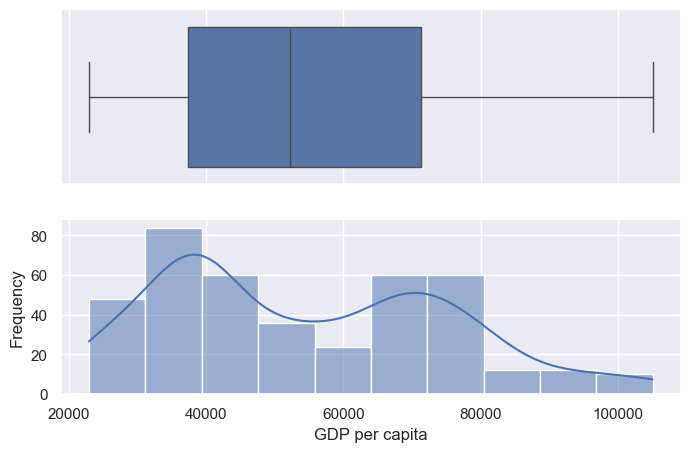

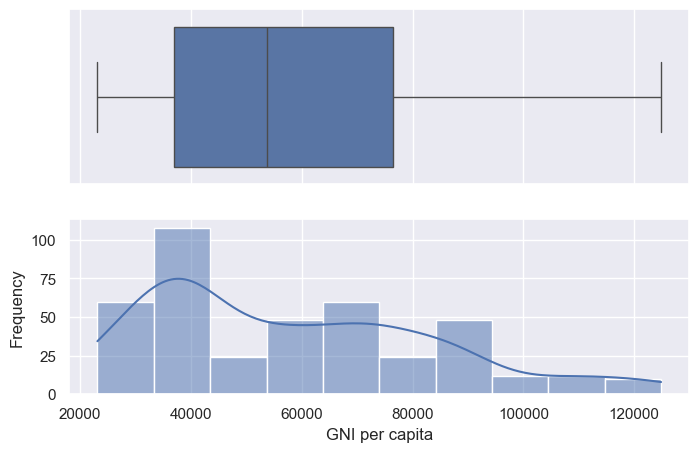

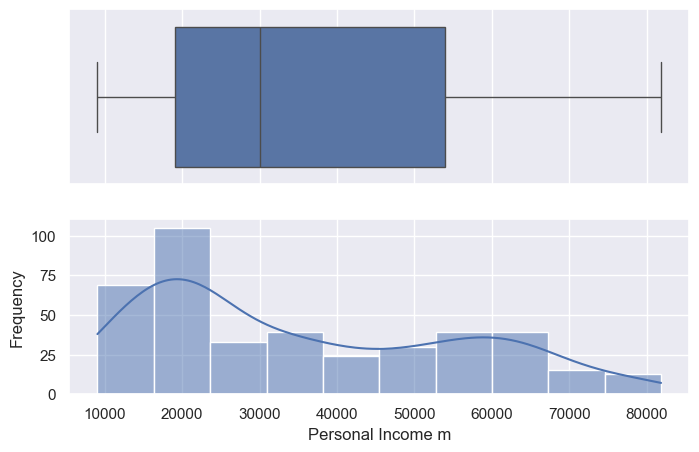

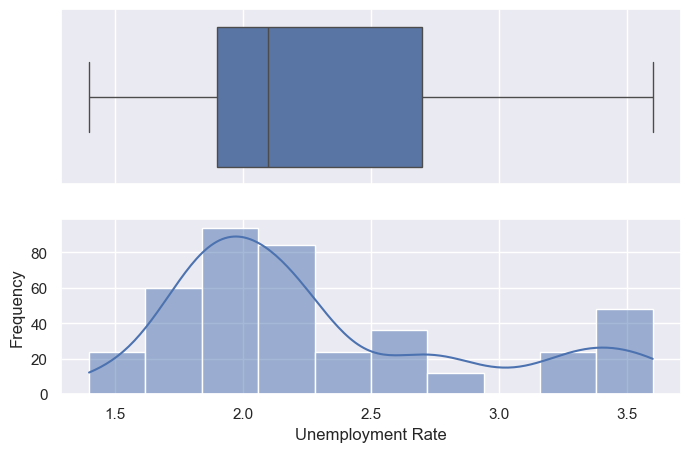

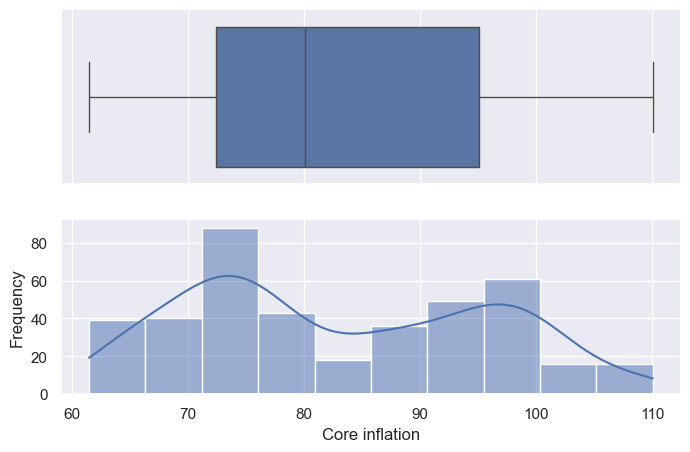

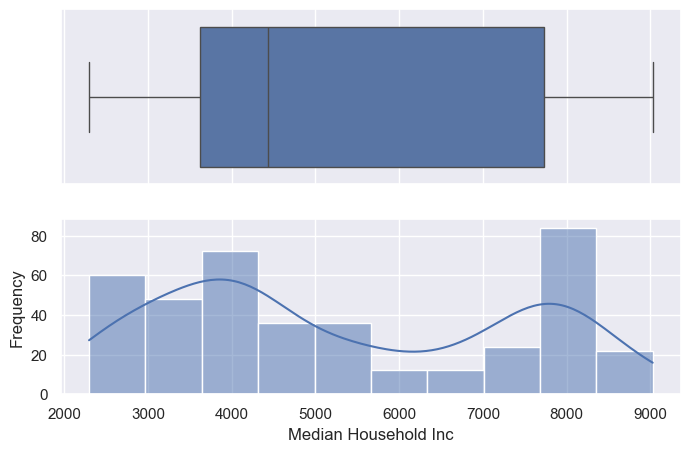

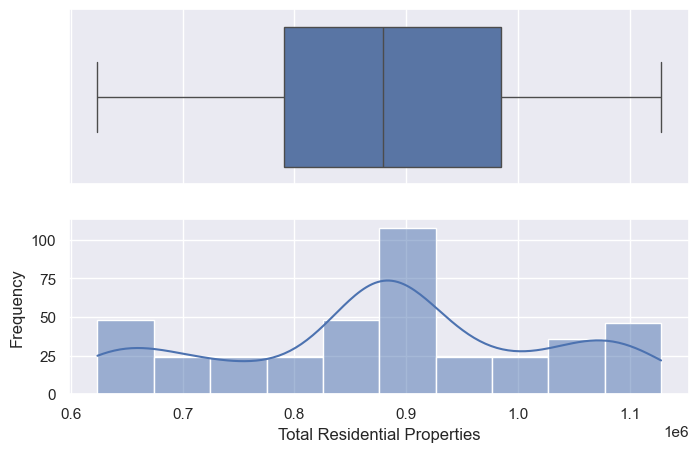

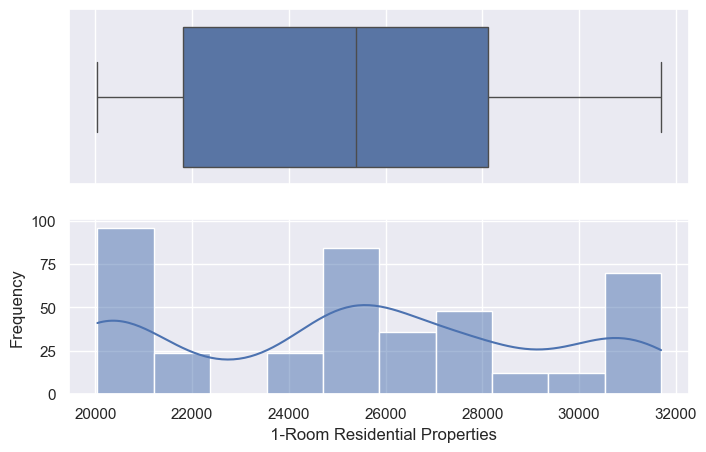

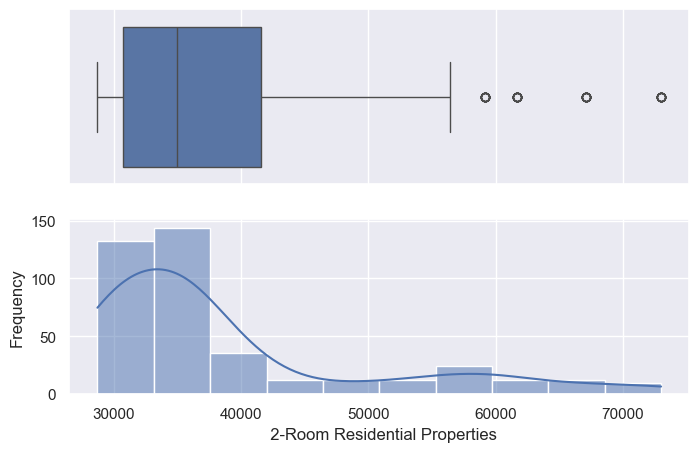

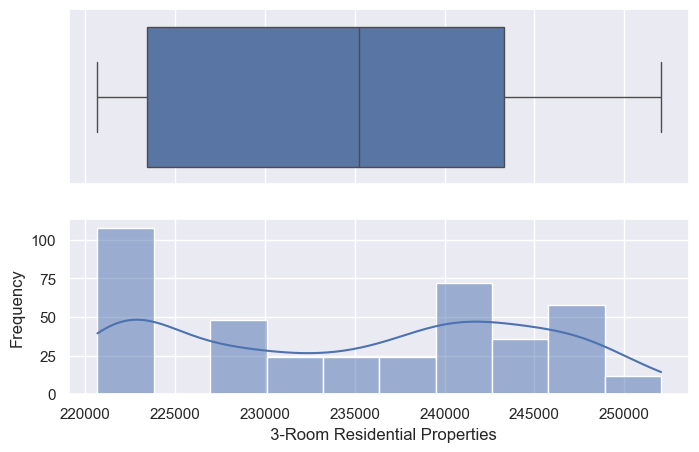

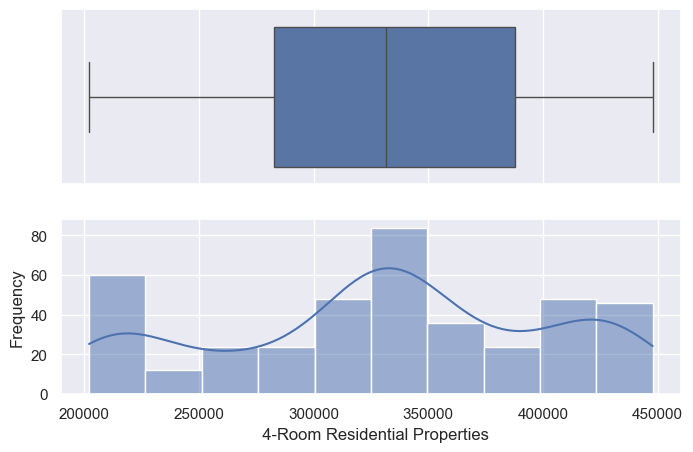

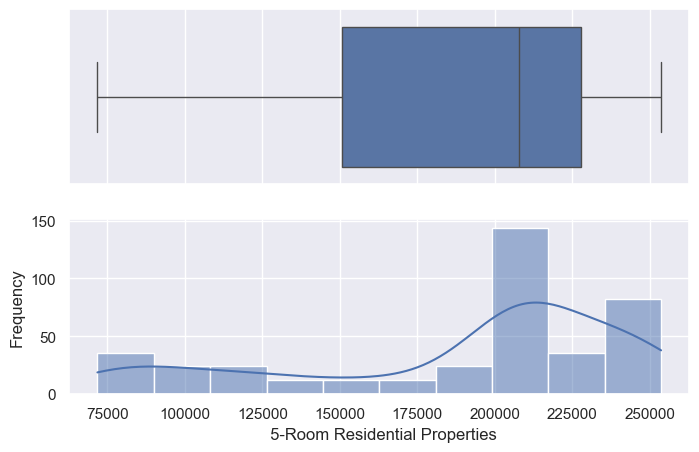

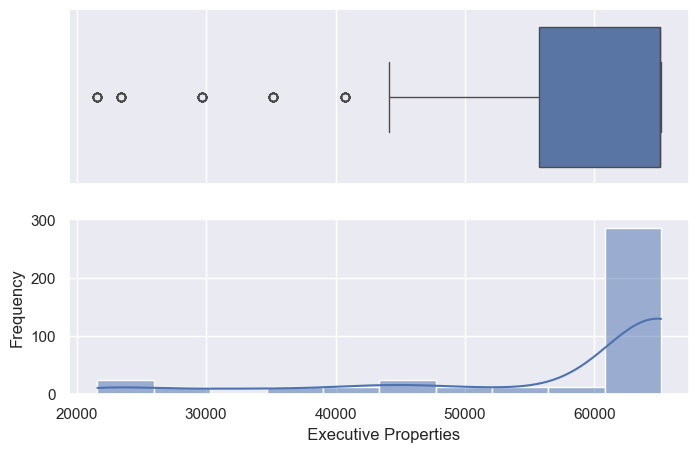

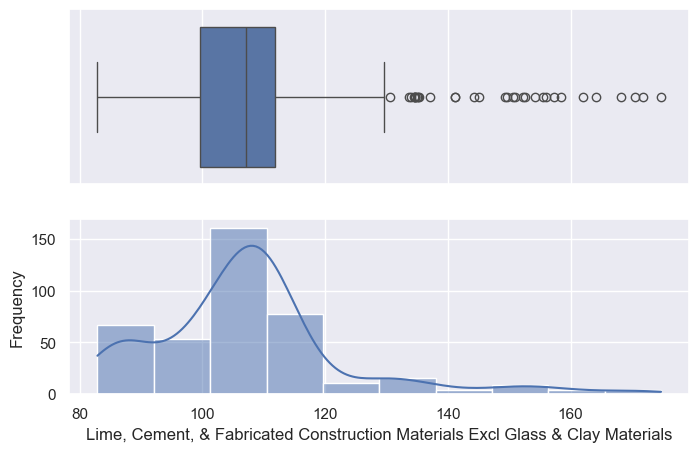

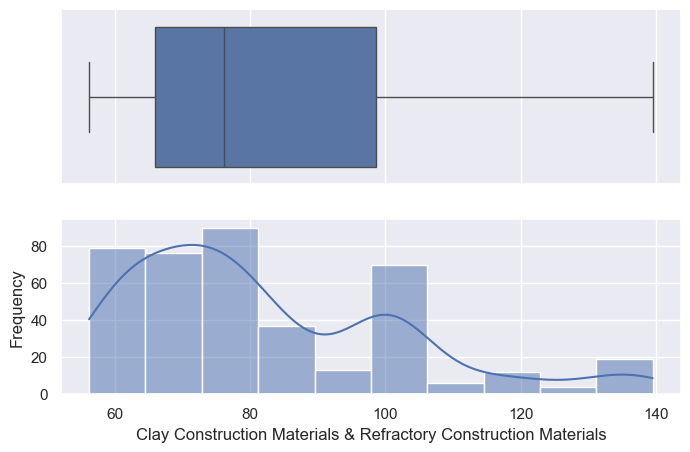

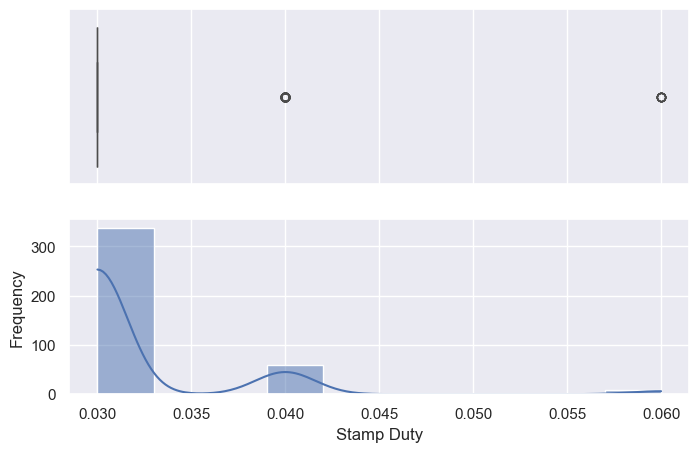

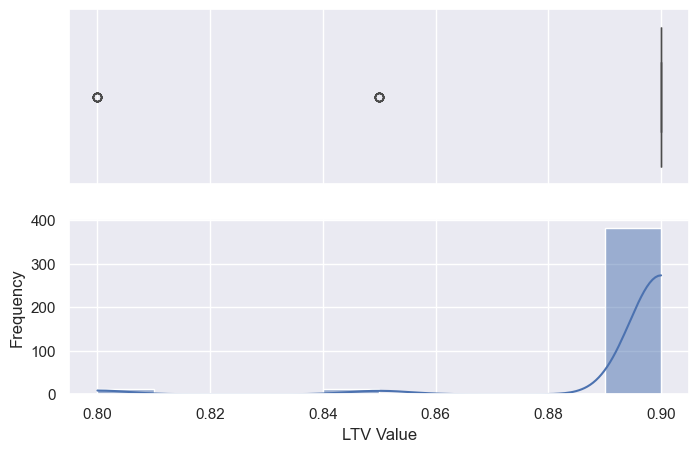

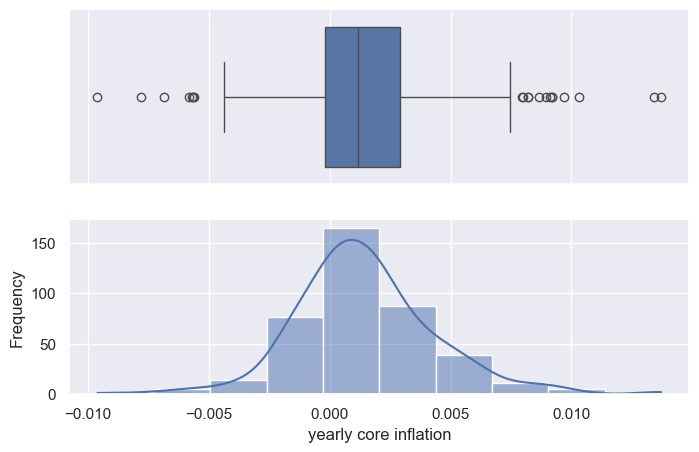

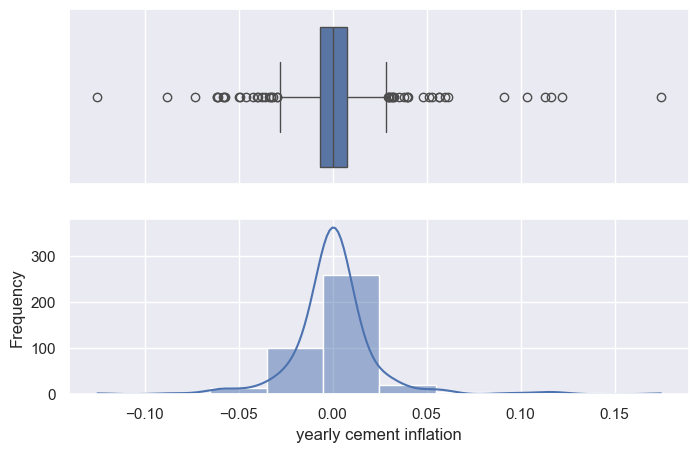

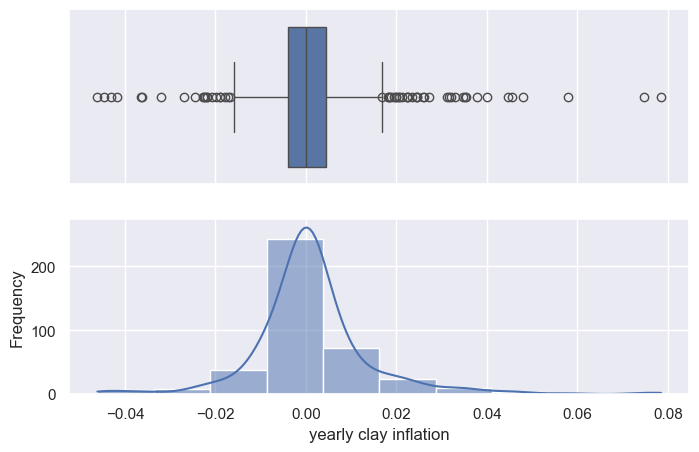

In [50]:
cols = data.select_dtypes(include=np.number).columns

for i in data[cols]:
    sns.set(rc={"figure.figsize":(8, 5)})
    # layer one plot on top of another on same axis
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i, ylabel='Frequency')
    sns.boxplot(x=data[i], ax=ax_box , linewidth= 1.0)
    sns.histplot(data[i], ax=ax_hist , bins = 10,kde=True)